# Fire Detection using Ensemble CNN Models

This notebook implements an ensemble of CNN models to detect fires in satellite and natural images. The ensemble approach combines predictions from multiple CNN architectures to achieve better performance than individual models.

## Setup and Dependencies

First, let's install and import the necessary libraries. We'll use kagglehub to download the dataset.

In [ ]:
# Install necessary packages
!pip install tensorflow numpy matplotlib pandas scikit-learn kagglehub pillow seaborn

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Download and Prepare Dataset

We'll use a fire detection dataset from Kaggle that includes images of fire and non-fire scenes.

In [ ]:
# Download the Forest Fire Detection dataset using kagglehub
# You need to authenticate with kaggle first: run 'kaggle authenticate' in terminal
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /kaggle/input/the-wildfire-dataset


In [ ]:
# Define paths to dataset directories
# Adjust these paths based on your dataset structure
DATA_DIR = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version'
!ls -la {DATA_DIR}

total 0
drwxr-sr-x 5 1000 1000 0 Apr  1 13:46 .
drwxr-sr-x 3 1000 1000 0 Apr  1 13:48 ..
drwxr-sr-x 4 1000 1000 0 Apr  1 13:44 test
drwxr-sr-x 4 1000 1000 0 Apr  1 13:45 train
drwxr-sr-x 4 1000 1000 0 Apr  1 13:46 val


In [ ]:
# Setup data directories - adjust based on your dataset structure
# For example, if the data is organized in 'fire' and 'non-fire' directories:
FIRE_DIR = os.path.join(DATA_DIR, 'fire')
NON_FIRE_DIR = os.path.join(DATA_DIR, 'non_fire')


## Data Preprocessing and Augmentation

Create data generators to load and preprocess images. We'll use data augmentation to improve model generalization.

In [ ]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data directories
train_dir = os.path.join(DATA_DIR, 'train')  # Update with your actual path
val_dir = os.path.join(DATA_DIR, 'val')      # Update with your actual path
test_dir = os.path.join(DATA_DIR, 'test')    # Update with your actual path

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data should only be rescaled
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Flow validation images in batches
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Flow test images in batches
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


## View Sample Images

Let's visualize some samples from our dataset to understand what we're working with.

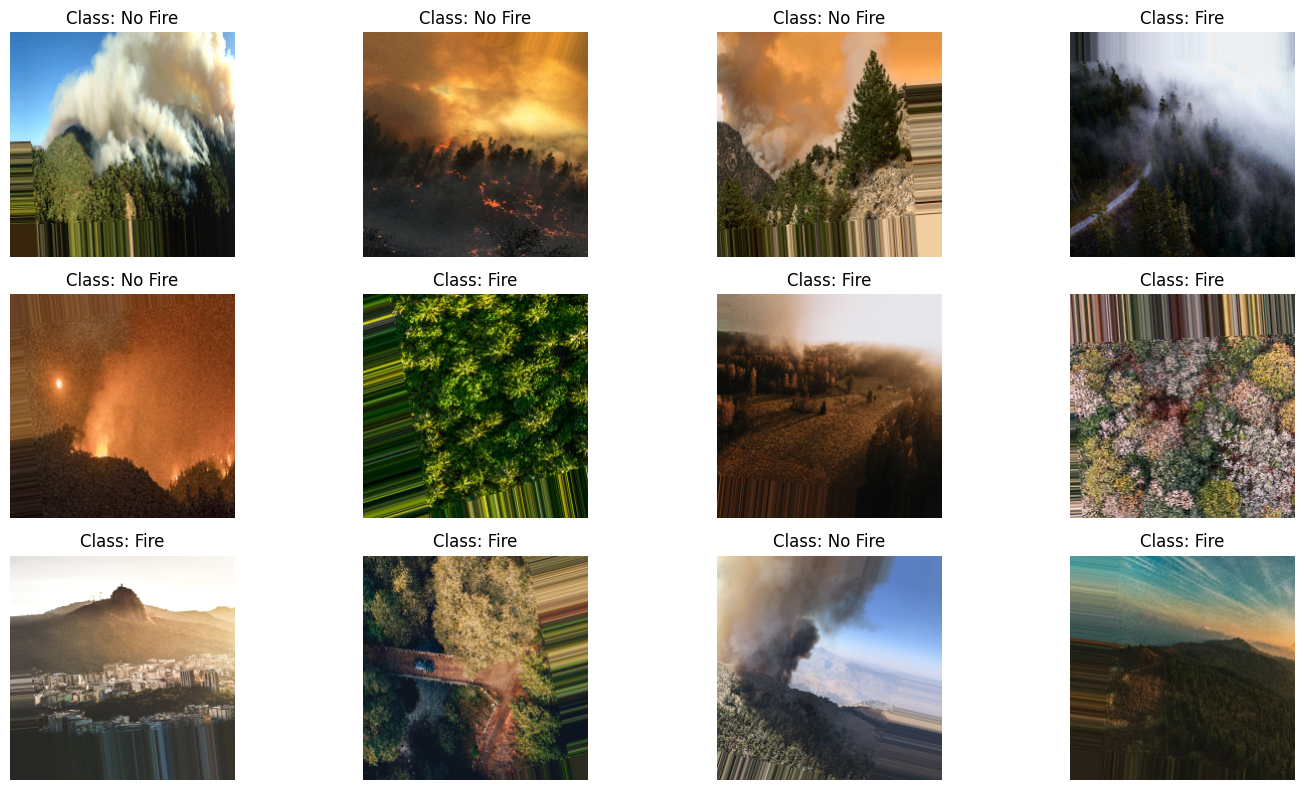

In [ ]:
# Get a batch of training images
images, labels = next(train_generator)

# Display sample images
plt.figure(figsize=(15, 8))
for i in range(min(12, len(images))):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {'Fire' if labels[i] > 0.5 else 'No Fire'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Build Individual CNN Models

We'll create three different CNN models using pre-trained architectures (VGG16, ResNet50, and InceptionV3) as base models.

In [ ]:
def create_cnn_model(base_model_name, trainable=False):
    """Create a CNN model based on a pre-trained architecture

    Args:
        base_model_name (str): Name of the pre-trained model to use ('vgg16', 'resnet50', or 'inception')
        trainable (bool): Whether to make the base model trainable

    Returns:
        A Keras model
    """
    # Define input shape
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

    # Create base model
    if base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'inception':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model name: {base_model_name}")

    # Freeze the base model if not trainable
    base_model.trainable = trainable

    # Add classification head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

## Train Individual Models

Now we'll train each individual CNN model separately.

In [ ]:
# Define callbacks
def create_callbacks(model_name):
    checkpoint = ModelCheckpoint(
        f'models/{model_name}_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]

# Create directory for saving models
os.makedirs('models', exist_ok=True)

In [ ]:
from google.colab import files

In [ ]:
# Train VGG16 model
print("Training VGG16 model...")
vgg_model = create_cnn_model('vgg16')
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=create_callbacks('vgg16')
)
vgg_model.save("vgg16_model.keras")
files.download("vgg16_model.keras")

Training VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
24/58 ━━━━━━━━━━━━━━━━━━━━ 4:09 7s/step - accuracy: 0.5516 - loss: 0.7765

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


33/58 ━━━━━━━━━━━━━━━━━━━━ 3:07 8s/step - accuracy: 0.5645 - loss: 0.7618

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5902 - loss: 0.7271
Epoch 1: val_accuracy improved from -inf to 0.74740, saving model to models/vgg16_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 554s 9s/step - accuracy: 0.5911 - loss: 0.7260 - val_accuracy: 0.7474 - val_loss: 0.5202 - learning_rate: 1.0000e-04
Epoch 2/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.7188 - loss: 0.5084

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.74740
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7188 - loss: 0.5084 - val_accuracy: 0.7448 - val_loss: 0.5170 - learning_rate: 1.0000e-04
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6951 - loss: 0.5545
Epoch 3: val_accuracy improved from 0.74740 to 0.80208, saving model to models/vgg16_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 504s 9s/step - accuracy: 0.6954 - loss: 0.5543 - val_accuracy: 0.8021 - val_loss: 0.4627 - learning_rate: 1.0000e-04
Epoch 4/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.7188 - loss: 0.5205
Epoch 4: val_accuracy did not improve from 0.80208
58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7188 - loss: 0.5205 - val_accuracy: 0.8021 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7503 - loss: 0.5134
Epoch 5: val_accuracy did not improve from 0.80208
58/58 ━━━━━━━━━━━━━━━━━━━━ 509s 9s/step - accuracy: 0.7504 - loss: 0.5133 - val_accuracy: 0.7839 - val_loss: 0.4785 - learning_rate: 1.0000e-04
Epoch 6/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.6562 - loss: 0.6364
Epoch 6: val_accuracy did not improve from 0.80208
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6562 - loss: 0.6364 - val_accuracy: 0.7656 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 7/20
58/58 

58/58 ━━━━━━━━━━━━━━━━━━━━ 467s 8s/step - accuracy: 0.7803 - loss: 0.4633 - val_accuracy: 0.8073 - val_loss: 0.4331 - learning_rate: 1.0000e-04
Epoch 8/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.8438 - loss: 0.4529
Epoch 8: val_accuracy did not improve from 0.80729
58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8438 - loss: 0.4529 - val_accuracy: 0.8047 - val_loss: 0.4280 - learning_rate: 1.0000e-04
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7789 - loss: 0.4476
Epoch 9: val_accuracy improved from 0.80729 to 0.81771, saving model to models/vgg16_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - accuracy: 0.7790 - loss: 0.4476 - val_accuracy: 0.8177 - val_loss: 0.4259 - learning_rate: 1.0000e-04
Epoch 10/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.8438 - loss: 0.3496
Epoch 10: val_accuracy did not improve from 0.81771
58/58 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8438 - loss: 0.3496 - val_accuracy: 0.8151 - val_loss: 0.4322 - learning_rate: 1.0000e-04
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7581 - loss: 0.4637
Epoch 11: val_accuracy did not improve from 0.81771
58/58 ━━━━━━━━━━━━━━━━━━━━ 559s 9s/step - accuracy: 0.7585 - loss: 0.4633 - val_accuracy: 0.8125 - val_loss: 0.4277 - learning_rate: 1.0000e-04
Epoch 12/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.7500 - loss: 0.6396
Epoch 12: val_accuracy improved from 0.81771 to 0.82292, saving model to models/vgg16_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7500 - loss: 0.6396 - val_accuracy: 0.8229 - val_loss: 0.4205 - learning_rate: 1.0000e-04
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8088 - loss: 0.4140
Epoch 13: val_accuracy improved from 0.82292 to 0.82552, saving model to models/vgg16_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 469s 8s/step - accuracy: 0.8088 - loss: 0.4141 - val_accuracy: 0.8255 - val_loss: 0.4018 - learning_rate: 1.0000e-04
Epoch 14/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.8750 - loss: 0.3460
Epoch 14: val_accuracy did not improve from 0.82552
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8750 - loss: 0.3460 - val_accuracy: 0.8125 - val_loss: 0.4018 - learning_rate: 1.0000e-04
Epoch 15/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8056 - loss: 0.4026
Epoch 15: val_accuracy did not improve from 0.82552
58/58 ━━━━━━━━━━━━━━━━━━━━ 503s 9s/step - accuracy: 0.8058 - loss: 0.4027 - val_accuracy: 0.8229 - val_loss: 0.4187 - learning_rate: 1.0000e-04
Epoch 16/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.7812 - loss: 0.5000
Epoch 16: val_accuracy did not improve from 0.82552
58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7812 - loss: 0.5000 - val_accuracy: 0.8177 - val_loss: 0.4238 - learning_rate: 1.0000e-04
Epoch 17/20


## Evaluate Individual Models

Let's evaluate the performance of each individual model.

In [ ]:
def evaluate_model(model, model_name):
    # Load the best saved model
    model = load_model(f'models/{model_name}_best.h5')

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

    # Predict on test set
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    y_true = test_generator.classes

    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Fire', 'Fire'],
                yticklabels=['No Fire', 'Fire'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['No Fire', 'Fire']))

    return y_pred

In [ ]:
# Evaluate each model
vgg_preds = evaluate_model(vgg_model, 'vgg16')
resnet_preds = evaluate_model(resnet_model, 'resnet50')
inception_preds = evaluate_model(inception_model, 'inception')

## Simple Voting Ensemble



In [ ]:
# Implement simple voting ensemble (average predictions)
voting_preds = (vgg_preds + resnet_preds + inception_preds) / 3
voting_classes = (voting_preds > 0.5).astype("int32")

# Get test labels
test_generator.reset()
y_true = test_generator.classes

# Calculate accuracy
voting_acc = accuracy_score(y_true, voting_classes)
print(f"Voting Ensemble Accuracy: {voting_acc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, voting_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fire', 'Fire'],
            yticklabels=['No Fire', 'Fire'])
plt.title('Voting Ensemble Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nVoting Ensemble Classification Report:")
print(classification_report(y_true, voting_classes, target_names=['No Fire', 'Fire']))

## Compare Model Performance

Let's compare the performance of all models.

In [ ]:
# Load histories
def plot_training_history(histories, model_names):
    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot all learning curves
plot_training_history(
    [vgg_history, resnet_history, inception_history],
    ['VGG16', 'ResNet50', 'InceptionV3']
)